<a href="https://colab.research.google.com/github/ZackAkil/stateful-object-tracking/blob/main/notebooks/player_detection_v1_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/ZackAkil/stateful-object-tracking/raw/main/trained_models/400_700_v2_68.h5

--2023-06-18 10:29:19--  https://github.com/ZackAkil/stateful-object-tracking/raw/main/trained_models/400_700_v2_68.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/trained_models/400_700_v2_68.h5 [following]
--2023-06-18 10:29:20--  https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/trained_models/400_700_v2_68.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 626104 (611K) [application/octet-stream]
Saving to: ‘400_700_v2_68.h5’

400_700_v2_68.h5    100%[===================>] 611.43K  --.-KB/s    in 0.01s   

2023-06-18 10:29:

In [4]:
from tensorflow import keras

# Load the saved model
model = keras.models.load_model("400_700_v2_68.h5")

In [5]:
import numpy as np

In [6]:
test_input = np.random.random([1, 400, 700, 3])
test_input.shape

(1, 400, 700, 3)

In [7]:
prediction = model.predict(test_input)

1/1 [==============================] - 7s 7s/step


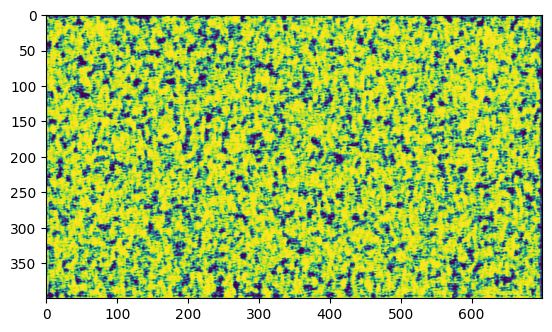

In [8]:
import matplotlib.pyplot as plt

plt.imshow(prediction[0])

In [9]:
import numpy as np
from scipy.ndimage import binary_dilation

def expand_islands(matrix, n=0):
    # Create a structuring element for dilation
    structure = np.ones((3, 3), dtype=int)

    # Perform binary dilation on the matrix
    dilated_matrix = binary_dilation(matrix, iterations=n)

    return dilated_matrix


from scipy.ndimage import label, sum

def remove_small_islands(matrix, n=100):
    labeled_matrix, num_features = label(matrix)  # Label connected components
    component_sizes = sum(matrix, labeled_matrix, range(num_features + 1))  # Calculate sizes

    # Create a mask to filter out small islands
    # print(component_sizes)
    mask = (component_sizes >= n)

    # Apply the mask to remove small islands
    filtered_matrix = mask[labeled_matrix]

    return filtered_matrix


from scipy.ndimage import label

def find_islands(matrix):

  # Apply the label function to find connected components
  labeled_matrix, num_labels = label(matrix)

  # Get the unique labels
  unique_labels = np.unique(labeled_matrix)

  boxes = []
  # Iterate over the unique labels (excluding background label 0)
  for label_value in unique_labels[1:]:
      # Create a mask for the current label
      mask = (labeled_matrix == label_value)

      # Find the indices of the ones in the mask
      indices = np.where(mask)

      avg_y = indices[0].mean()
      avg_x = indices[1].mean()

      min_x = indices[1].min()
      max_x = indices[1].max()

      min_y = indices[0].min()
      max_y = indices[0].max()

      box = {'pos':{'x':avg_x, 'y':avg_y}, 'bbox':{'min_x':min_x, 'max_x':max_x,
                                                   'min_y':min_y, 'max_y':max_y}}
      boxes.append(box)

  return boxes

def run_box_huristic(mask):

  porlarized_matrix = mask > 0.5

  expanded_pixels = expand_islands(porlarized_matrix, 1)

  removed_small_islands = remove_small_islands(expanded_pixels, n=50)

  boxes = find_islands(removed_small_islands)

  return boxes


In [10]:
!wget https://github.com/ZackAkil/stateful-object-tracking/raw/main/training_data/drone_45.mp4

--2023-06-18 10:30:21--  https://github.com/ZackAkil/stateful-object-tracking/raw/main/training_data/drone_45.mp4
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/training_data/drone_45.mp4 [following]
--2023-06-18 10:30:22--  https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/training_data/drone_45.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25046252 (24M) [application/octet-stream]
Saving to: ‘drone_45.mp4’

drone_45.mp4        100%[===================>]  23.89M  --.-KB/s    in 0.1s    

2023-06-18 10:30:28 (183 MB/s) - ‘d

In [11]:
import cv2

# Path to the video file
video_path = 'drone_45.mp4'

# Open the video file
video = cv2.VideoCapture(video_path)


In [12]:
ret, frame = video.read()

In [13]:

frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


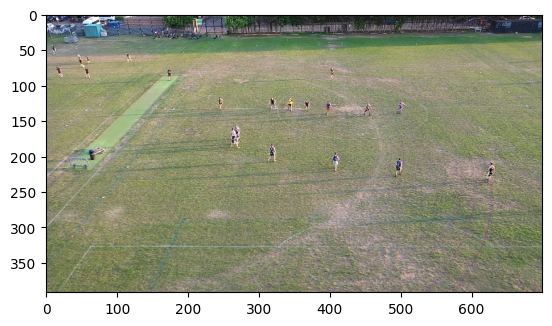

In [14]:
plt.imshow(frame_np)

In [15]:
# Resize the image to the desired dimensions
resized_image = cv2.resize(frame_np, (700, 400))

# Normalize and convert to numpy array
resized_image = resized_image / 255.0
resized_image = np.expand_dims(resized_image, axis=0)

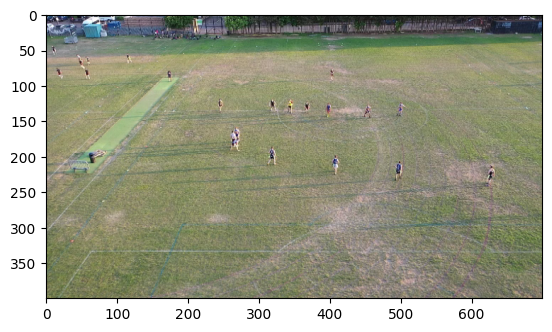

In [16]:
plt.imshow(resized_image[0])

In [17]:
prediction = model.predict(resized_image)

1/1 [==============================] - 0s 23ms/step


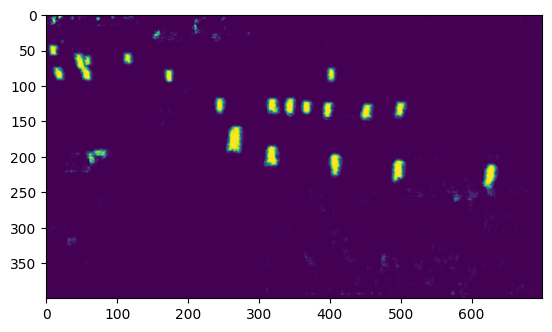

In [18]:
plt.imshow(prediction[0])

In [19]:
def plot_boxes(image, bboxes, save=None):

  # plt.imshow(labeled_matrix)
  plt.clf()
  plt.imshow(image)

  # Set the plot aspect ratio to equal
  plt.gca().set_aspect('equal')

  # Iterate over the unique labels (excluding background label 0)
  for box in bboxes:

      avg_y = box['pos']['y']
      avg_x = box['pos']['x']

      min_x = box['bbox']['min_x']
      max_x = box['bbox']['max_x']

      min_y = box['bbox']['min_y']
      max_y = box['bbox']['max_y']

      x, y = avg_x, avg_y
      circle = plt.Circle((x, y), radius=2, color='red', fill=True)

      rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                         linewidth=1, edgecolor='r', facecolor='none')
      plt.gca().add_patch(circle)
      plt.gca().add_patch(rect)
      plt.axis('off')
  if save:
    plt.savefig(f'{save}.png', bbox_inches='tight', pad_inches=0)
  else:
    plt.show()


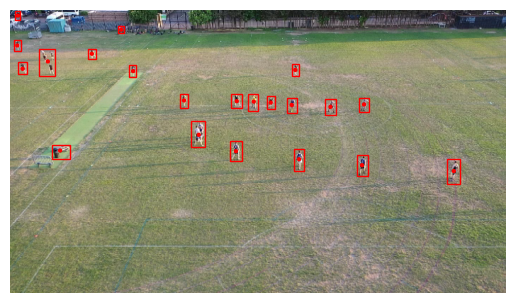

In [20]:
prediction_boxes = run_box_huristic(prediction[0])

plot_boxes(resized_image[0], prediction_boxes, save="1")

In [22]:
!mkdir predictions

490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
10/10 [==============================] - 3s 302ms/step
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
7

IndexError: ignored

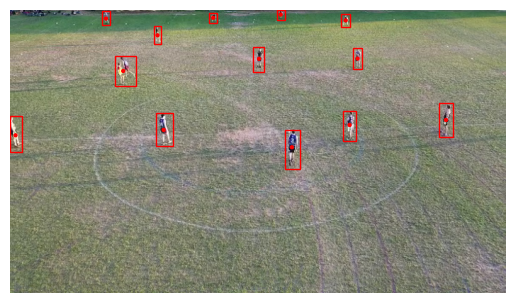

In [25]:
# Path to the video file
video_path = 'drone_45.mp4'

# Open the video file
video = cv2.VideoCapture(video_path)
index = 0

batch = 300

while True:

    images = []
    for i in range(batch):

      # Read the next frame
      success, frame = video.read()
      # Check if frame reading was successful
      if not success:
          break
      frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      # Resize the image to the desired dimensions
      resized_image = cv2.resize(frame_np, (700, 400))
      images.append(resized_image)

    resized_images = np.array(images)
    # Normalize and convert to numpy array
    resized_image = resized_images / 255.0
    # resized_image = np.expand_dims(resized_image, axis=0)
    prediction = model.predict(resized_image)

    for i in range(batch):

      prediction_boxes = run_box_huristic(prediction[i])
      index += 1
      plot_boxes(resized_images[i], prediction_boxes, save=f'predictions/{index}')
      print(index)


In [27]:
!ffmpeg -framerate 10 -i predictions/1%d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264 -crf 23 -pix_fmt yuv420p output1.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
import cv2
import os

# Path to the folder containing the images
folder_path = 'predictions'

# Get a list of all image files in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Specify the output video settings
output_video_path = 'output_video.mp4'
fps = 25.0  # Frames per second
frame_size = (496,283)  # Specify the frame size (width, height)

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the video codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

# Iterate over each image file and write it to the video

for i in range(1000):
    image_path = f'predictions/{i}.png'
    frame = cv2.imread(image_path)
    out.write(frame)

# Release the VideoWriter
out.release()


In [28]:
!zip -r output.zip predictions

  adding: predictions/ (stored 0%)
  adding: predictions/1016.png (deflated 0%)
  adding: predictions/808.png (deflated 0%)
  adding: predictions/541.png (deflated 0%)
  adding: predictions/450.png (deflated 0%)
  adding: predictions/1071.png (deflated 0%)
  adding: predictions/28.png (deflated 0%)
  adding: predictions/1124.png (deflated 0%)
  adding: predictions/92.png (deflated 0%)
  adding: predictions/977.png (deflated 0%)
  adding: predictions/932.png (deflated 0%)
  adding: predictions/286.png (deflated 0%)
  adding: predictions/221.png (deflated 0%)
  adding: predictions/869.png (deflated 0%)
  adding: predictions/985.png (deflated 0%)
  adding: predictions/121.png (deflated 0%)
  adding: predictions/130.png (deflated 0%)
  adding: predictions/1033.png (deflated 0%)
  adding: predictions/400.png (deflated 0%)
  adding: predictions/262.png (deflated 0%)
  adding: predictions/129.png (deflated 0%)
  adding: predictions/815.png (deflated 0%)
  adding: predictions/764.png (deflated